 taken from https://astrofrog.github.io/py4sci/
 
 expanded on by implimenting fit quality analysis (p-value) and estimating background contamination

# Part 1
# Particle Decay

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit #simpliest scipy fitting method
import scipy.special as sf # needed for p-value calculation

%matplotlib notebook


The rate of decay of a radioactive element is given by:

$N(t) = N_0 e^{-t/\tau}$

where,
* $N$ is the number of particles
* $N_0$ is the initial amount of particles at time $t=0$
* $\tau$ is the mean life time

Often we talk about the half life of radioactive materials. The half life, $t_{1/2}$, is the time taken for the activity of a given amount of radioactive substance to reach half of it's initial amount. evaluating our equation at the half life time:

$N(t=t_{1/2}) = \frac{N_0}{2} = N_0 e^{-t_{1/2}/\tau}$

$\Rightarrow \frac{1}{2} = e^{-t_{1/2}/\tau}$ $\,\,\Rightarrow \ln(\frac{1}{2}) = -\frac{t_{1/2}}{\tau}$

$\Rightarrow \ln(2) = \frac{t_{1/2}}{\tau}$

$\Rightarrow t_{1/2} = \tau\ln(2)$


In [ ]:
#t, N, N_error = np.loadtxt('data/decay_data.txt', unpack=True)

In [2]:
#read in data
t, N, N_error = np.loadtxt('data/decay_data.txt', unpack=True)

<IPython.core.display.Javascript object>


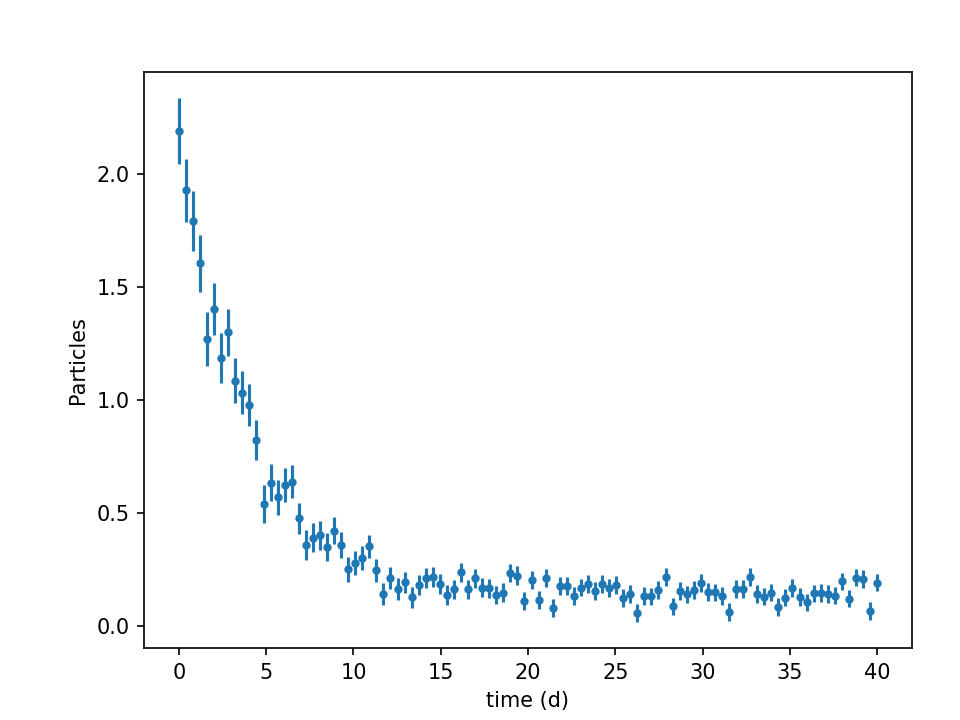

In [3]:
fig = plt.figure()
axes = fig.add_axes([0.15,0.1,0.8,0.8])

axes.errorbar(t, N, yerr = N_error, fmt='.')
axes.set_xlabel('time (d)')
axes.set_ylabel('Particles');

Fit data using exponential

In [4]:
def func_exp(t,a,b):
    return a*np.exp(-t/b)

Important Note: the way curve_fit determines the uncertainty is to actually renormalize the errors so that the reduced χ2

value is one, so the magnitude of the errors doesn't matter, only the relative errors. In some fields of science (such as astronomy) we do not renormalize the errors, so for those cases you can specify absolute_sigma=True in order to preserve the original errors.

# Fitting the Data

We will use **curve_fit** from the scipy.optimize library:
>curve_fit (function, x_data, y_data, sigma, absolute_sigma)

* function = function that we want to use to describe the data
* x_data = our x data 
* y_data = our y data
* sigma = the error associated with the y data
* absolute_sigma = tells curve_fit to use the listed error values as the uncertainties in y_data

curve_fit returns two quantities:
1. optimal fit parameters (named popt below)
2. covariant matrix, e.g. the uncertianties on the fit parameters (named pcov below)

In [5]:
popt,pcov = curve_fit(func_exp, t, N, sigma=N_error, absolute_sigma=True)

print('Initial fit:')
print(popt)
print('\n')
print(pcov)

Initial fit:
[1.3212484  8.88344297]


[[ 0.00165526 -0.00778983]
 [-0.00778983  0.05711712]]


# What does the Fit Result look like?

<IPython.core.display.Javascript object>


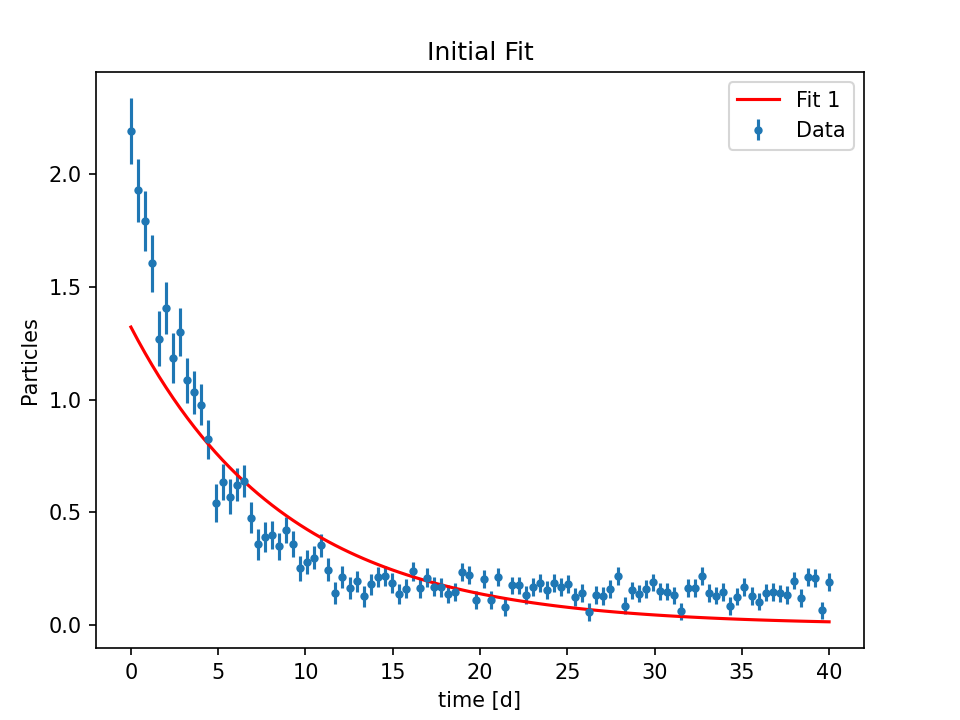

In [6]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_title('Initial Fit')
axes.set_xlabel('time [d]')
axes.set_ylabel('Particles')

axes.errorbar(t, N, yerr = N_error, fmt='.', label = 'Data')

axes.plot(t, func_exp(t,*popt),'r-', label = 'Fit 1');
plt.legend();

# Let's Calculate $\chi^2$

Risidual: $r = y^{data} - y^{fit}$

Scipy obtains optimized parameters via minimizing the sum of the squared residuals
$\sum_i r^{2}_{i}$

A common metric of how well the fit is, is based on it's $\chi^2$

$\chi^2 = \sum_{i} \frac{\left(y^{data}_i - y^{fit}_{i} \right)^2}{\sigma^2_{i}} =  \sum_{i} \frac{r_{i}^2}{\sigma^2_{i}}$

Reduced $\chi^2$ = $\chi^2_{R} = \frac{\chi^2}{N-p}$, where
* $N$ = number of data points
* $p$ = number of fit parameter

A fit is considered good if $\chi^2_R \approx 1$


In [8]:
Fit1_chisq = np.sum( (N - func_exp(t,*popt))**2/(N_error**2) )
dof = len(N) - len(popt)

print('Fit 1 results:\n')
print(' chi2 = ',Fit1_chisq,'\n dof = ', dof, '\n reduced chi2 = ', Fit1_chisq/dof)

Fit 1 results:

 chi2 =  660.0176843252075 
 dof =  98 
 reduced chi2 =  6.734874329849056


# Error Propogation

From out covariant matrix returned by our fit using the function:
$$N(t) = N_0 e^{-t/\tau},$$

We found from our fit that $\tau$ with in some uncertainty $\delta \tau$

In [ ]:
print('Fit Results:', popt)
print('\n')
print('Covariance Matrix:')
print(pcov)

Fit1_tau = popt[1]
Fit1_tau_error = pcov[1,1]**0.5
print('\n tau = ',Fit1_tau,'days +/-', Fit1_tau_error,' days')

## Find the uncertianty on the half life $(t_{1/2})$

Assume we have a function $f = ab$, then 

$$ \delta f^2 = \delta a^2 \left|\frac{\partial f}{\partial a}\right|^2 + \delta b^2 \left|\frac{\partial f}{\partial b}\right|^2 + 2\left|\frac{\partial f}{\partial a}\right|\left|\frac{\partial f}{\partial b}\right|\delta ab $$

The half life and mean life time are related:
$$t_{1/2} = \tau\ln{2}$$

$$f\rightarrow t_{1/2}$$
$$a\rightarrow \tau$$
$$\delta a \rightarrow \delta \tau$$

$$(\delta t_{1/2})^2 = (\delta \tau)^2(\ln{2})^2$$

In [ ]:
#Fit1_tau = popt[1]
#Fit1_tau_error = pcov[1,1]

Fit1_t = Fit1_tau*np.log(2)
Fit1_t_error = np.sqrt(Fit1_tau_error**2 * np.log(2)**2)
print('\n Half life = ', Fit1_t, 'days +/- ', Fit1_t_error,' days \n')

# Part 2
We can evaluate the p-value from *scipy.special* using 
> sf.gammaincc( $dof/2.0$, $\chi^2/2.0$ )

In [9]:
#check chiq
Fit1_chisq = np.sum( (N - func_exp(t,*popt))**2/(N_error**2) )
dof = len(N) - len(popt)

Fit1_pvalue = sf.gammaincc(dof/2.0,Fit1_chisq/2.0)

print('Fit 1 results:\n')
print(' chi2 = ',Fit1_chisq,'\n dof = ', dof, '\n reduced chi2 = ', Fit1_chisq/dof, '\n p-value = ',Fit1_pvalue)

Fit 1 results:

 chi2 =  660.0176843252075 
 dof =  98 
 reduced chi2 =  6.734874329849056 
 p-value =  3.4858019083599277e-84


## <span style="color:red"> Switch to In-Class Notebook </span>

In [10]:
def func_exp_bkg(t,a,b,bkg):
    return a*np.exp(-t/b) + bkg

In [11]:
popt2, pcov2 = curve_fit(func_exp_bkg, t, N, sigma=N_error, absolute_sigma=True)

In [12]:

print('Second fit:')
print(popt2)
print('\n')
print(pcov2)

Second fit:
[2.03895771 3.82202621 0.146625  ]


[[ 5.13987020e-03 -7.07479214e-03  4.42248403e-05]
 [-7.07479214e-03  2.06004028e-02 -3.32916925e-04]
 [ 4.42248403e-05 -3.32916925e-04  2.73710159e-05]]


In [13]:
Fit2_tau_error = pcov2[1,1]**0.5
Fit2_tau = popt2[1]
print('\n tau = ',Fit2_tau,'1/d +/-', Fit2_tau_error,' 1/d')

Fit2_t = popt2[1]*np.log(2)
Fit2_t_error = Fit2_t * np.sqrt((Fit2_tau_error/Fit2_tau)**2)
print('\n Half live = ', Fit2_t, 'd +/- ', Fit2_t_error,' d \n')


 tau =  3.822026205845453 1/d +/- 0.14352840415712165  1/d

 Half live =  2.649226688608001 d +/-  0.09948630867177721  d 



<IPython.core.display.Javascript object>


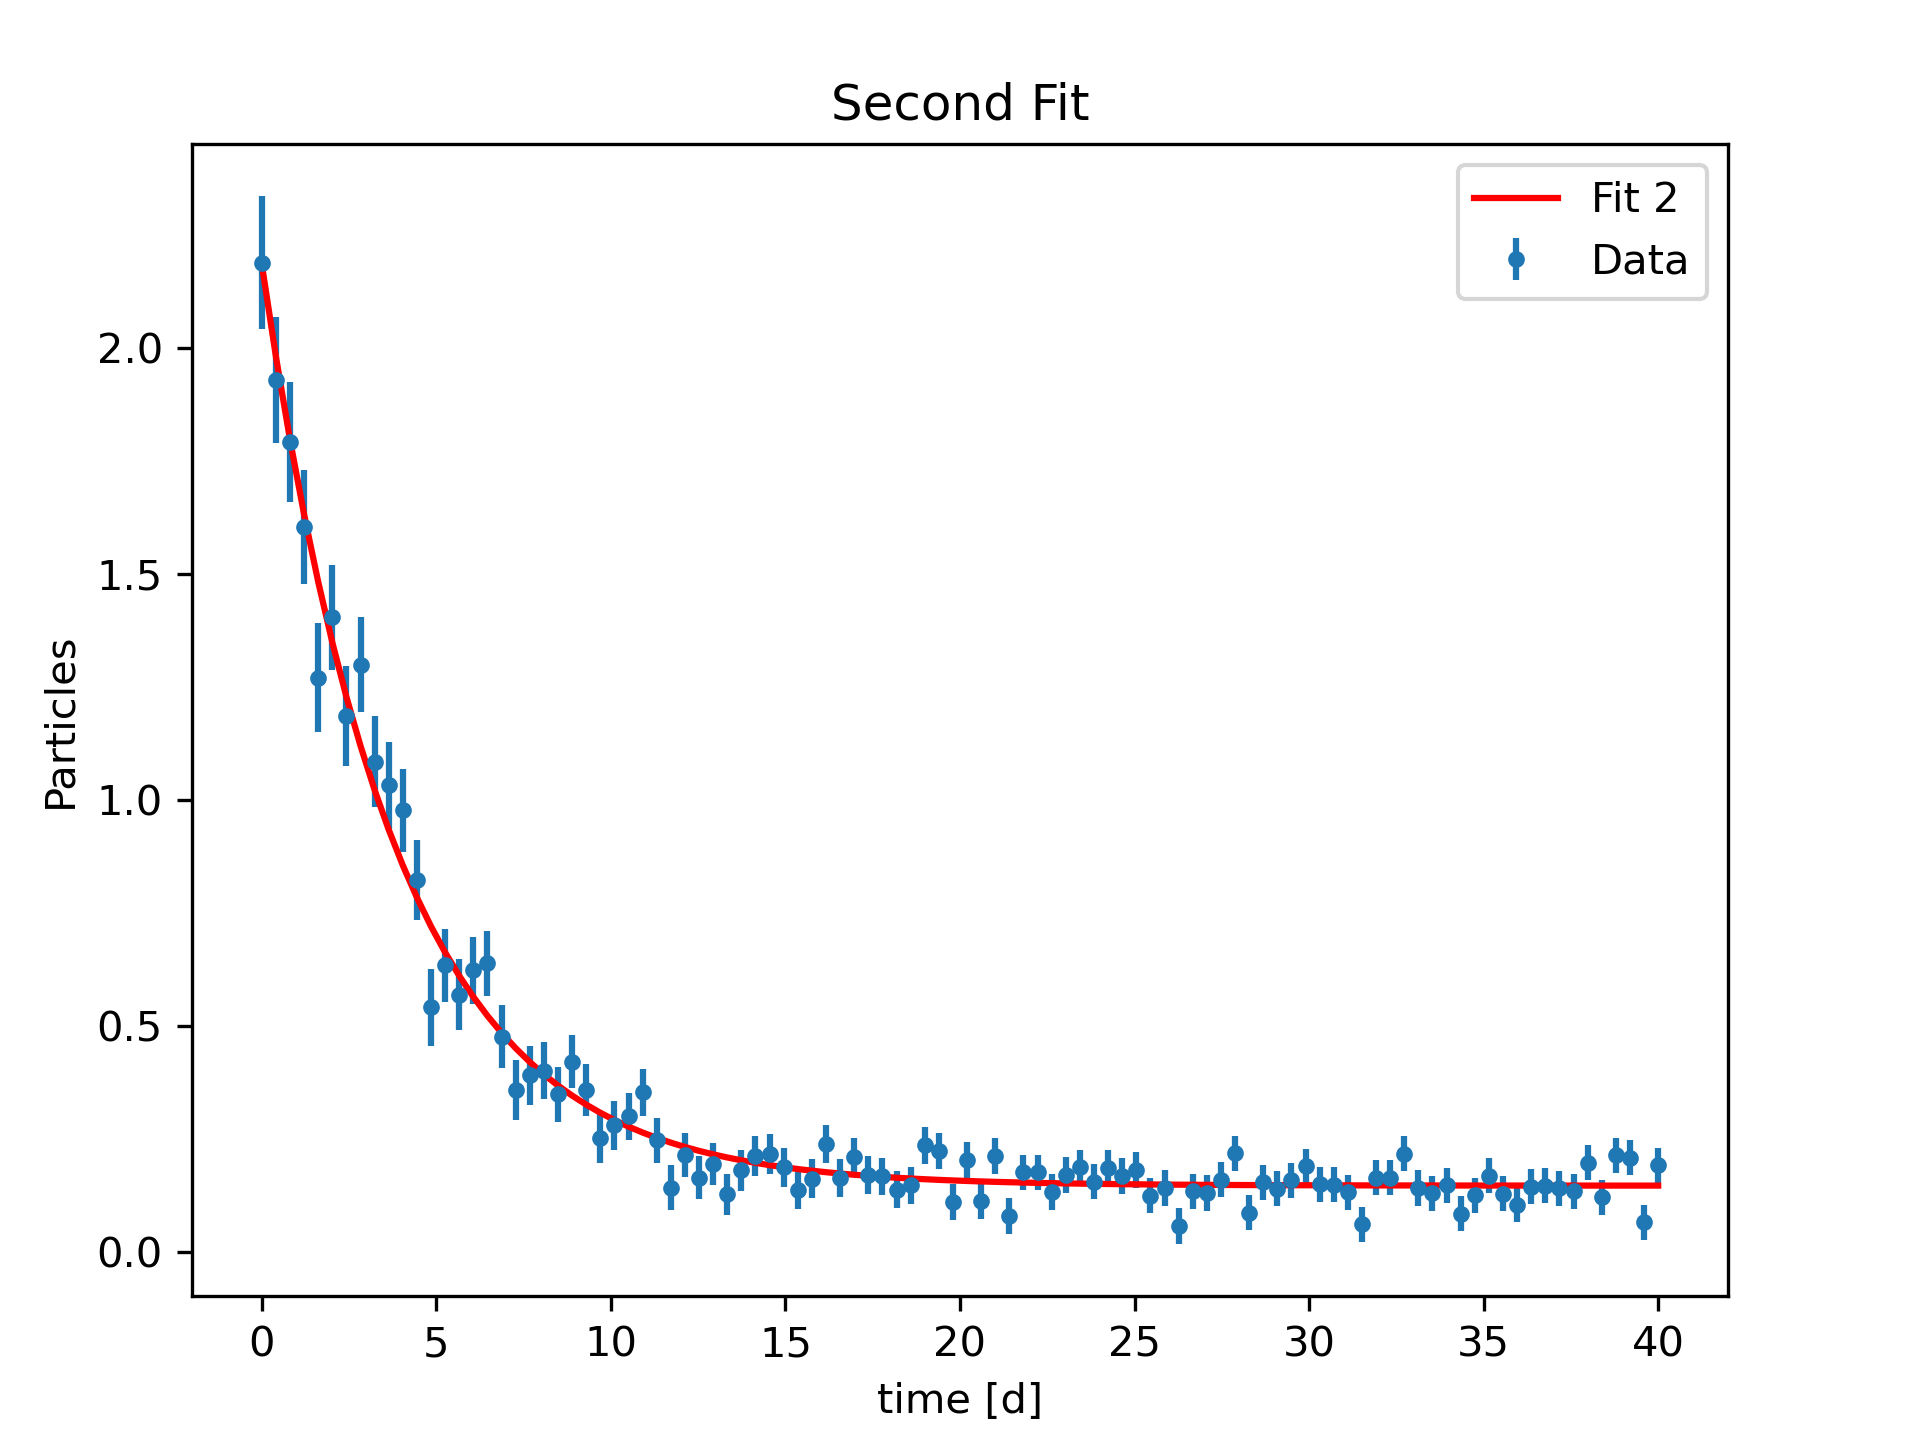

In [14]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.errorbar(t,N,yerr = N_error, fmt='.', label = 'Data')
axes.plot(t,func_exp_bkg(t,*popt2),'r-', label = 'Fit 2')

axes.set_title('Second Fit')
axes.set_xlabel('time [d]')
axes.set_ylabel('Particles')
axes.legend()


In [15]:
#check chiq
Fit2_chisq = np.sum( (N - func_exp_bkg(t,*popt2))**2/N_error**2)
dof_2 = len(N) - len(popt2)

#p-value
Fit2_pvalue = sf.gammaincc(dof_2/2.0, Fit2_chisq/2.0)

print('Fit 2 results:\n')
print(' chi2 = ',Fit2_chisq,'\n dof = ', dof_2, '\n reduced chi2 = ', Fit2_chisq/dof_2, '\n p-value = ',Fit2_pvalue)

Fit 2 results:

 chi2 =  100.93476476825121 
 dof =  97 
 reduced chi2 =  1.0405645852397032 
 p-value =  0.37202466972848836


# Part 3
Lets look at the contributions to the data from the signal and background

In [17]:
N_bkg = np.repeat(popt2[2],len(t))
N_bkg

array([0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146625,
       0.146625, 0.146625, 0.146625, 0.146625, 0.146625, 0.146

<IPython.core.display.Javascript object>


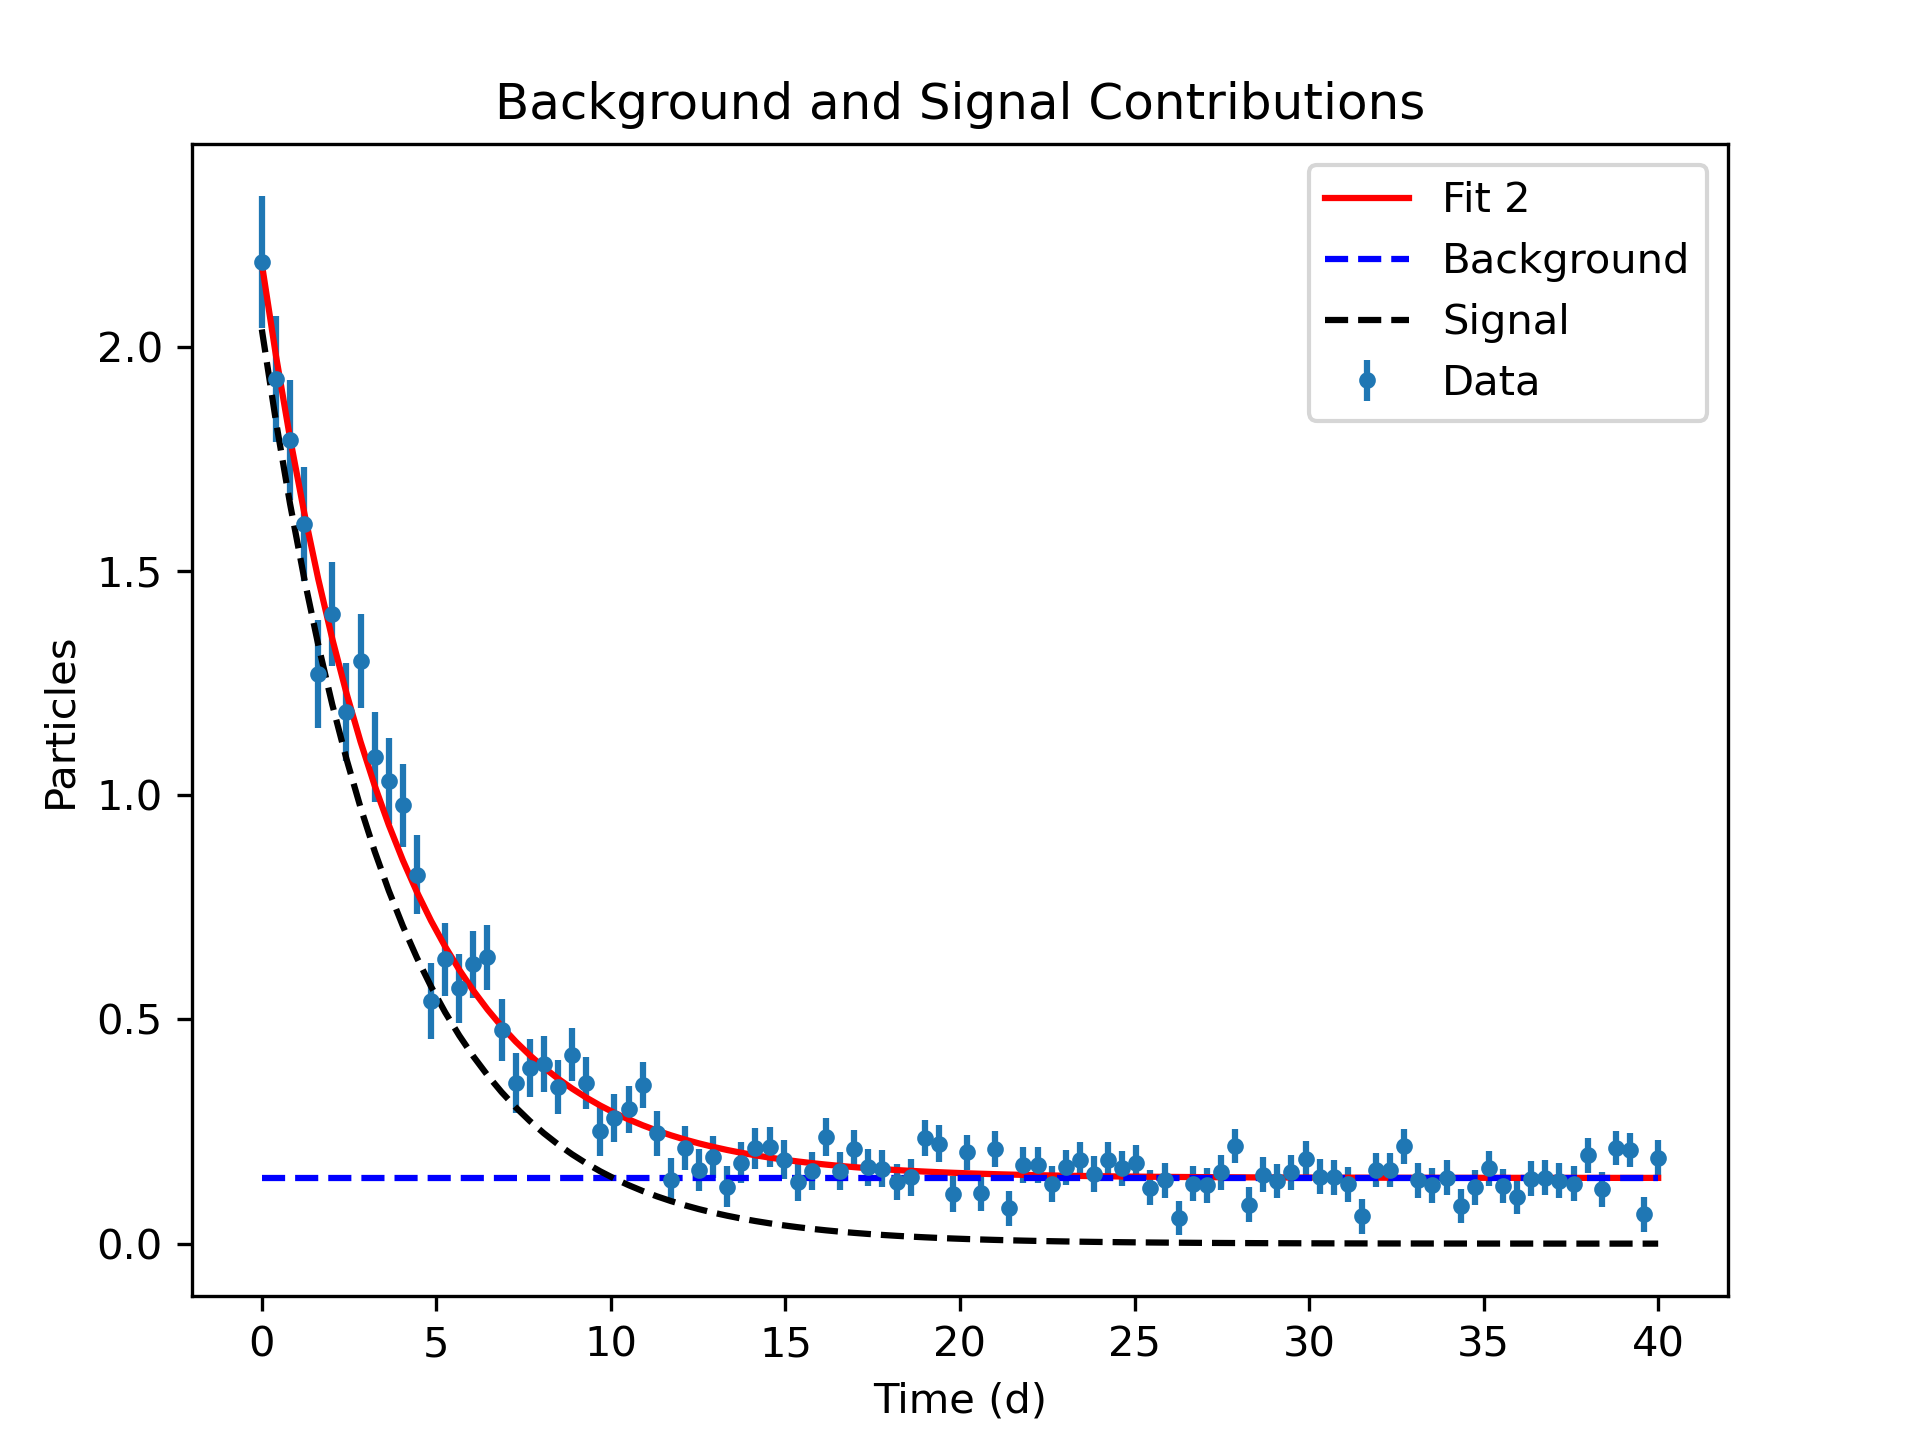

In [19]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.errorbar(t,N,yerr = N_error, fmt='.', label = 'Data')
axes.plot(t,func_exp_bkg(t,*popt2),'r-', label = 'Fit 2')
axes.plot(t,N_bkg,'b--', label = 'Background')
axes.plot(t,func_exp(t,popt2[0],popt2[1]),'k--', label = 'Signal')
axes.set_xlabel('Time (d)')
axes.set_ylabel('Particles')
axes.set_title('Background and Signal Contributions')
axes.legend();

We can look at the background contamination as a function of time by usign the ratio of background / (background + signal)

In [20]:
BS = 100.0* N_bkg/(N_bkg + func_exp(t,popt2[0],popt2[1]))

<IPython.core.display.Javascript object>


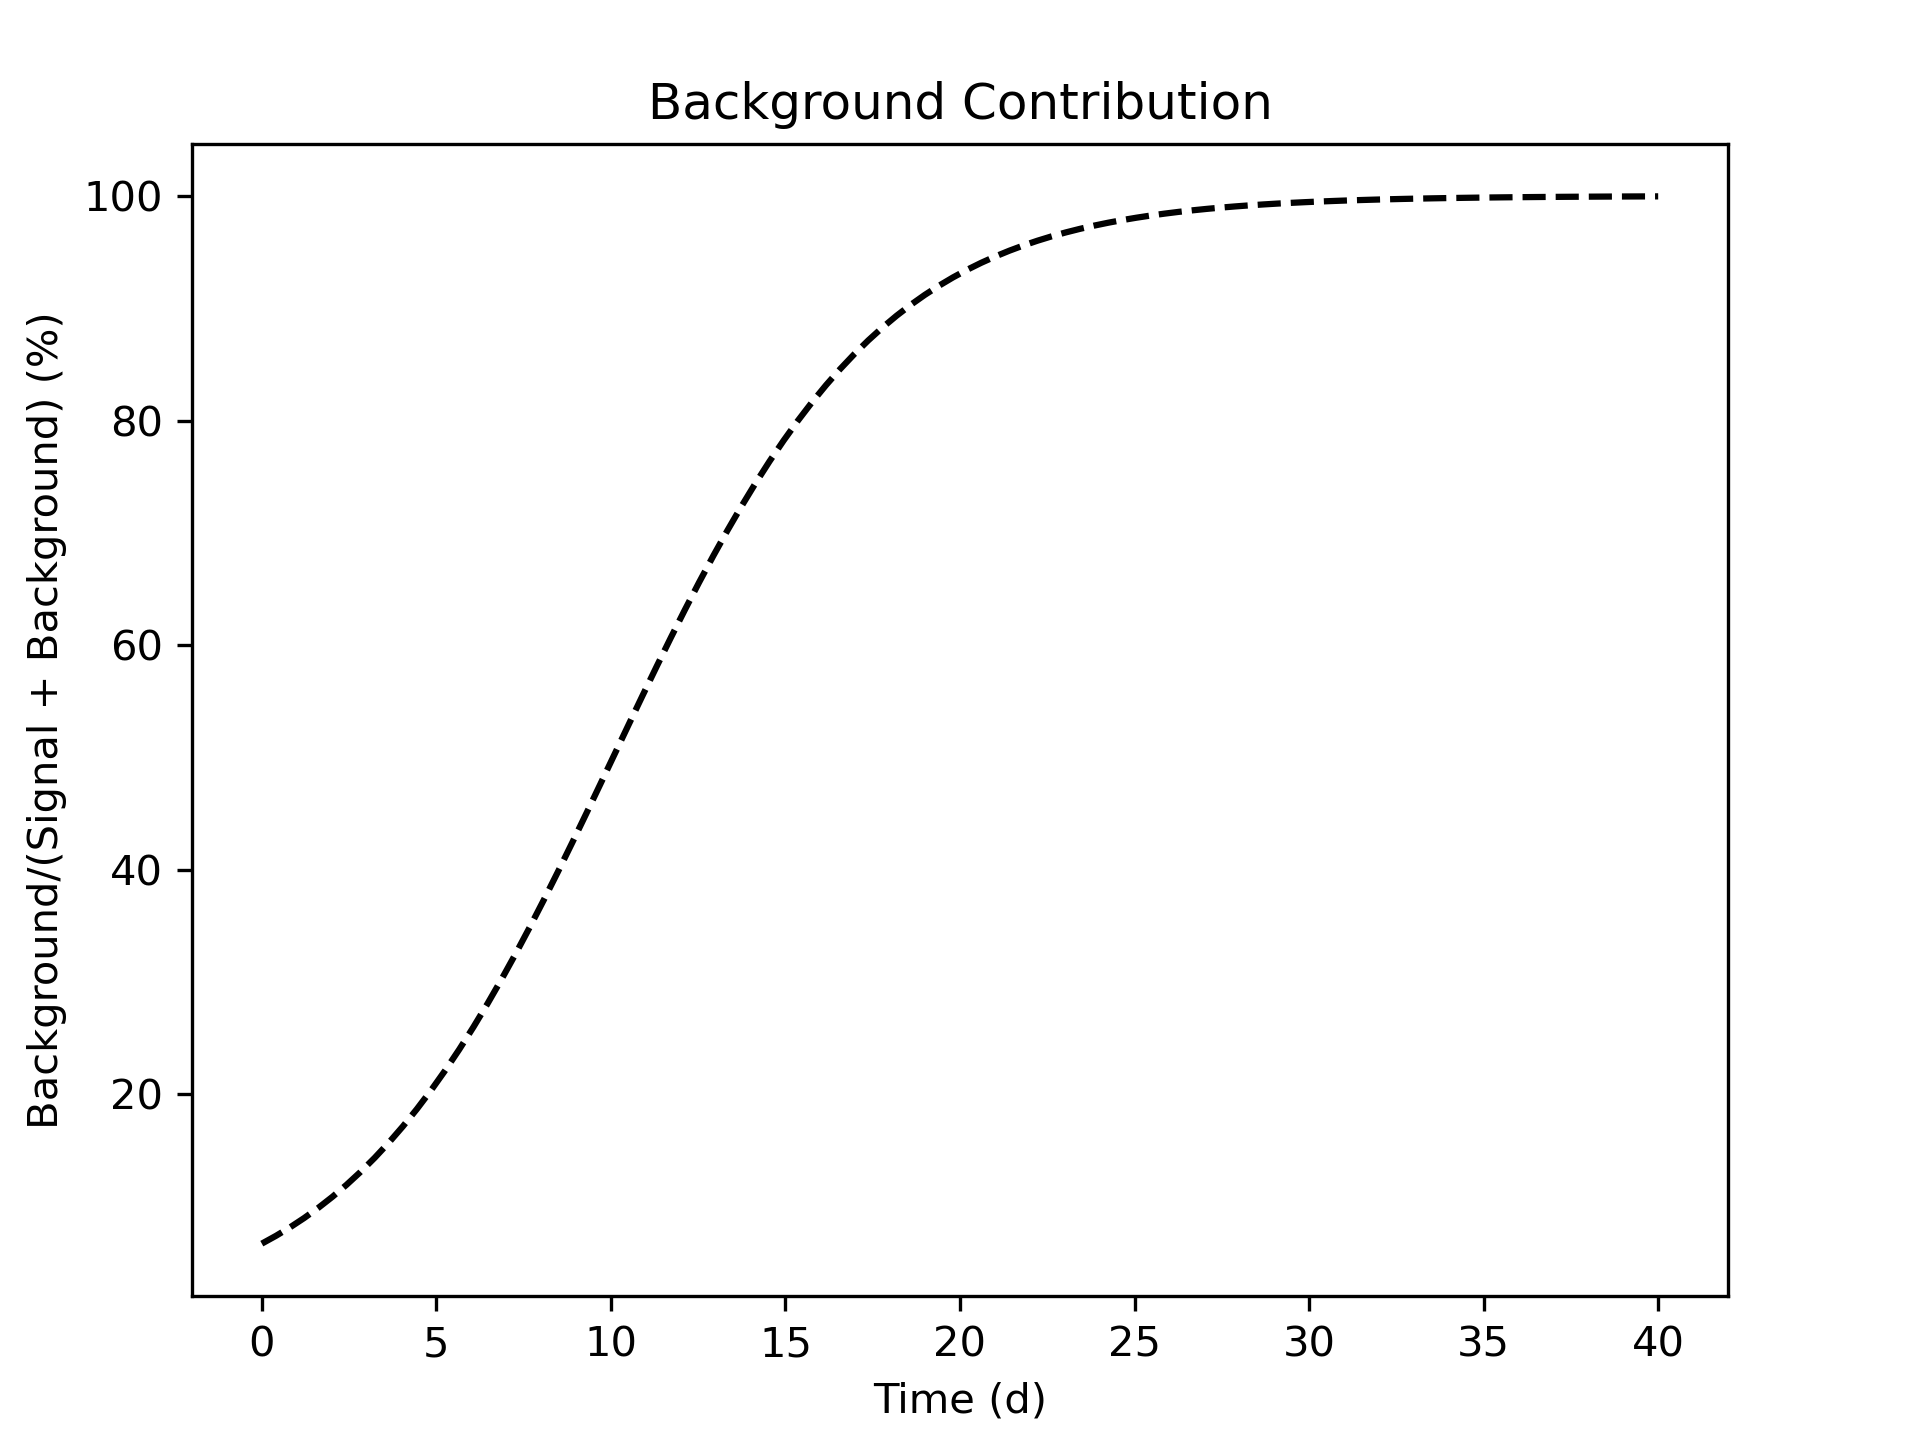

In [21]:

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(t,BS,'k--')
axes.set_xlabel('Time (d)')
axes.set_ylabel('Background/(Signal + Background) (%)')
axes.set_title('Background Contribution');
